In [1]:
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import clear_output, display, Image


In [2]:
def calculate_angle(a, b, c):
    """Calculate the angle (in degrees) at point b formed by points a, b, and c."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))
    
    return min(angle, 360 - angle)  # Always return smallest angle


In [3]:
# ----------------- Video and Pose Setup -----------------
video_path = "shoulder_flexibility.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0: fps = 30.0

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils  # Corrected line

# ----------------- Flexibility Tracking Variables -----------------
max_angles = {
    'abduction': 0,
    'flexion': 0,
    'extension': 0,
    'external_rotation': 0,
    'internal_rotation': 180
}

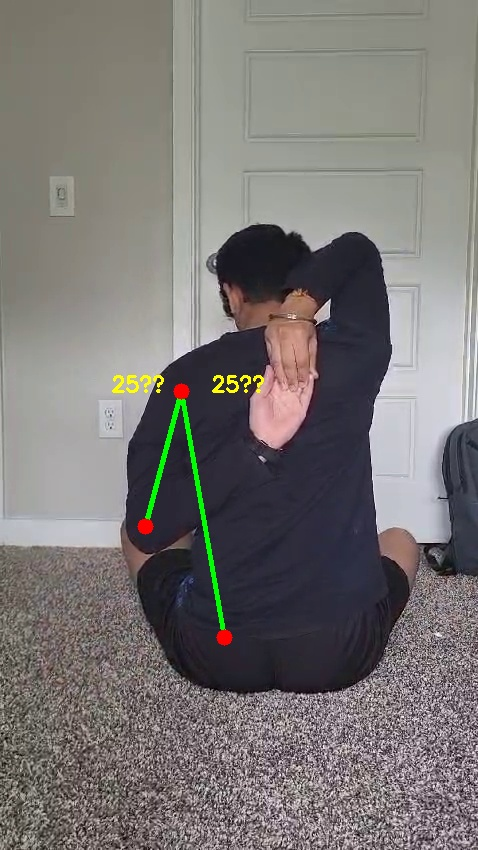

In [4]:
# ----------------- Processing Loop -----------------
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    h, w, _ = image.shape

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        
        # Left side landmarks
        ls = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * h))
        le = (int(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y * h))
        lh = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * h))
        lw = (int(landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x * w),
              int(landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y * h))

        # Visual Connections
        cv2.line(image, ls, le, (0,255,0), 3)    # Shoulder to elbow
        cv2.line(image, ls, lh, (0,255,0), 3)    # Shoulder to hip
        cv2.circle(image, ls, 8, (0,0,255), -1)  # Shoulder joint
        cv2.circle(image, le, 8, (0,0,255), -1)  # Elbow joint
        cv2.circle(image, lh, 8, (0,0,255), -1)  # Hip joint

        # Calculate angles
        abduction = calculate_angle(le, ls, lh)
        flexion = calculate_angle(lh, ls, le)
        extension = calculate_angle(lh, ls, le) if le[0] < ls[0] else 0
        
        # Angle annotations
        cv2.putText(image, f"{abduction:.0f}°", 
                   (ls[0]+30, ls[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        cv2.putText(image, f"{flexion:.0f}°", 
                   (ls[0]-70, ls[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)
        
        # Update max angles
        max_angles['abduction'] = max(max_angles['abduction'], abduction)
        max_angles['flexion'] = max(max_angles['flexion'], flexion)
        
        # Extension tracking
        if le[0] < ls[0]:  # Elbow behind shoulder
            if extension < max_angles['extension']:
                max_angles['extension'] = extension
                cv2.putText(image, f"{extension:.0f}°", 
                          (ls[0]-70, ls[1]+50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

        # Rotation analysis
        if abduction > 80:
            elbow_angle = calculate_angle(ls, le, lw)
            cv2.putText(image, f"R:{elbow_angle:.0f}°", 
                       (le[0]+20, le[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
            if 70 < elbow_angle < 110:
                if lw[1] < le[1]: 
                    max_angles['external_rotation'] = max(max_angles['external_rotation'], elbow_angle)
                else:
                    if elbow_angle < max_angles['internal_rotation']:
                        max_angles['internal_rotation'] = elbow_angle

    # Display frame
    ret2, buffer = cv2.imencode('.jpg', image)
    if ret2:
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))

cap.release()

In [5]:
# ----------------- Comprehensive Analysis -----------------
analysis = [
    ("Abduction (180° Goal)", max_angles['abduction'], 
    "Lateral movement capacity - crucial for overhead activities"),
    
    ("Flexion (180° Goal)", max_angles['flexion'],
    "Forward reaching ability - important for pushing motions"),
    
    ("Extension (45-60° Goal)", max_angles['extension'],
    "Backward mobility - essential for pulling movements"),
    
    ("External Rotation (90° Goal)", max_angles['external_rotation'],
    "Outward rotation - critical for throwing motions"),
    
    ("Internal Rotation (90° Goal)", max_angles['internal_rotation'],
    "Inward rotation - important for daily activities")
]

print("╔══════════════════════════════════════════════════╗")
print("║           SHOULDER FLEXIBILITY ANALYSIS          ║")
print("╠══════════════════════════╦═════════╦═════════════╣")
print("║        Movement          ║  Angle  ║  Status     ║")
print("╠══════════════════════════╬═════════╬═════════════╣")

for movement, angle, note in analysis:
    if "Abduction" in movement or "Flexion" in movement:
        status = "Excellent" if angle >= 170 else "Good" if angle >= 150 else "Needs Work"
    elif "Extension" in movement:
        status = "Optimal" if 45 <= angle <= 60 else "Limited"
    else:  # Rotations
        status = "Full ROM" if angle >= 85 else "Partial ROM"
    
    print(f"║ {movement:24} ║ {angle:6.1f}° ║ {status:11} ║")
    print(f"║ {'Note: ' + note:47} ║")
    print("╠══════════════════════════╬═════════╬═════════════╣")

print("╚══════════════════════════╩═════════╩═════════════╝")
print("\nRecommendations:")
if max_angles['extension'] < 45:
    print("- Focus on posterior shoulder stretches")
if max_angles['external_rotation'] < 85:
    print("- Incorporate sleeper stretches for external rotation")
if max_angles['internal_rotation'] > 95:
    print("- Improve internal rotation with cross-body stretches")

╔══════════════════════════════════════════════════╗
║           SHOULDER FLEXIBILITY ANALYSIS          ║
╠══════════════════════════╦═════════╦═════════════╣
║        Movement          ║  Angle  ║  Status     ║
╠══════════════════════════╬═════════╬═════════════╣
║ Abduction (180° Goal)    ║  156.8° ║ Good        ║
║ Note: Lateral movement capacity - crucial for overhead activities ║
╠══════════════════════════╬═════════╬═════════════╣
║ Flexion (180° Goal)      ║  156.8° ║ Good        ║
║ Note: Forward reaching ability - important for pushing motions ║
╠══════════════════════════╬═════════╬═════════════╣
║ Extension (45-60° Goal)  ║    0.0° ║ Limited     ║
║ Note: Backward mobility - essential for pulling movements ║
╠══════════════════════════╬═════════╬═════════════╣
║ External Rotation (90° Goal) ║  105.4° ║ Full ROM    ║
║ Note: Outward rotation - critical for throwing motions ║
╠══════════════════════════╬═════════╬═════════════╣
║ Internal Rotation (90° Goal) ║  180.0° ║ Full R